<a id="tutorial"></a>
# Load flow calculation with distributed slack

In power flow analysis, a slack bus is chosen which compensates the mismatch of active power in the grid as related to the balance of consumption, generation and losses. This mismatch results from grid losses or an unbalanced dispatch. In real transmission and distribution systems, multiple generators can play a role in compensating the mismatch of active power. The approach of _distributed slack_ allows to model the allocation of the mismatch compensation to a number of buses according to pre-defined weights, which more closely resembles real-world scenarios. To describe how much active power a single element contributes to the compensation of the mismatch of active power, the parameter *slack_weight* is used. 

In pandapower, the load flow calculation with Newton-Raphson algorithm supports the functionality of distributed slack. To this end, the user can set the argument *distributed_slack* to True when calling the function runpp. The slack weights for *ext_grid*, *gen* and *xward* elements should be provided in the *slack_weight* column.

### How the slack weight is considered
The sum of all slack weights of the contributing elements should be 1 and must be greater than 0. If the sum of the slack weights is other than 1, it is normalized to 1 before the load flow calculation. If the net has exactly one slack, e.g. an ext_grid, and only this element has a slack_weight other than 0, a load flow calculation considering distributed slack will have the same results as a load flow calculation without using the distributed slack (details in the first example below).

<a id='power_flow'></a>
### How the active power mismatch is attributed to the elements
The resulting active power of an element $i$ after the load flow calculation with distributed slack can be represented as follows ($ng$: number of generation plants, $nc$: number of consumptions, $nb$: number of branches):

<a id="sign"></a>
$$P_{result,i}= P_{set,i} - (\sum_{elm=1}^{ng}P_{generation,elm} - \sum_{elm=1}^{nc}P_{consumption,elm} - \sum_{branch=1}^{nb}P_{losses,branch}) \cdot slack\_weight_i$$

### Calculation example
We import necessary modules and create an example grid model:

<IPython.core.display.Javascript object>


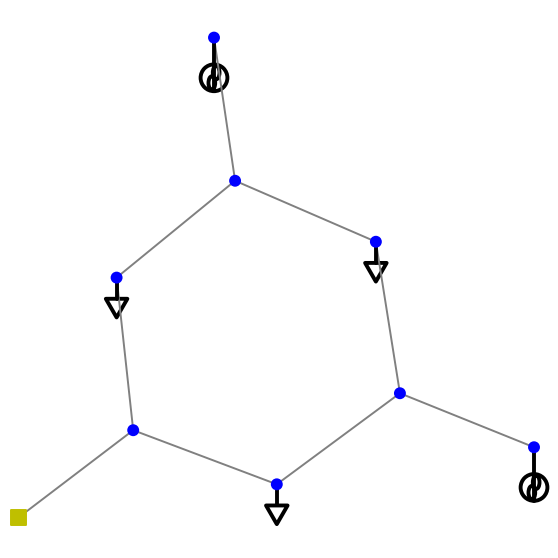

In [4]:
# configures the rendering and features of plots which use matplotlib:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook

from copy import deepcopy
import pandapower as pp
import pandapower.plotting
import networks as nw

from IPython.display import display, Markdown

net = nw.case9()
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot()
pp.plotting.simple_plot(net, plot_loads=True, plot_gens=True, load_size=2.5, gen_size=0.1, ax=ax);
fig.tight_layout(pad=0)

<a id="first_case"></a>
## First example: distributed slack with just the ext_grid element
In each case, we first define the contributing elements and their slack weights. Then we compare the results of the load flow calculation with and without the distributed slack calculation.

In [5]:
def print_powers(net):
    print(f"Consumption of loads:\t\t\t {net.load.at[0, 'p_mw']:>6.2f} MW\t {net.load.at[1, 'p_mw']:>6.2f} MW\t {net.load.at[2, 'p_mw']:>6.2f} MW\t ({net.load.p_mw.sum():>6.2f} MW total)")
    print(f"Injection of generators (input):\t {net.gen.at[0, 'p_mw']:>6.2f} MW\t {net.gen.at[1, 'p_mw']:>6.2f} MW\t\t\t ({net.gen.p_mw.sum():>6.2f} MW total)")
    print(f"Injection of generators (results):\t {net.res_gen.at[0, 'p_mw']:>6.2f} MW\t {net.res_gen.at[1, 'p_mw']:>6.2f} MW\t\t\t ({net.res_gen.p_mw.sum():>6.2f} MW total)")
    print(f"Injection of generators (difference):\t {net.res_gen.at[0, 'p_mw']-net.gen.at[0, 'p_mw']:>6.2f} MW\t {net.res_gen.at[1, 'p_mw']-net.gen.at[1, 'p_mw']:>6.2f} MW\t\t\t ({net.res_gen.p_mw.sum()-net.gen.p_mw.sum():>6.2f} MW total)")
    print(f"Slack power at ext_grid (results):\t {net.res_ext_grid.at[0, 'p_mw']:>6.2f} MW")
    print(f"Line losses (results):\t\t\t {net.res_line.pl_mw.sum():>6.2f} MW")

In [6]:
display(Markdown("#### Without distributed slack"))
pp.runpp(net)

print_powers(net)

display(Markdown("#### With distributed slack"))
# set slack_weight of the relevant elements
net.ext_grid['slack_weight'] = 1
net.gen['slack_weight'] = 0

pp.runpp(net, distributed_slack=True)

print_powers(net)

#### Without distributed slack

Consumption of loads:			  90.00 MW	 100.00 MW	 125.00 MW	 (315.00 MW total)
Injection of generators (input):	 163.00 MW	  85.00 MW			 (248.00 MW total)
Injection of generators (results):	 163.00 MW	  85.00 MW			 (248.00 MW total)
Injection of generators (difference):	   0.00 MW	   0.00 MW			 (  0.00 MW total)
Slack power at ext_grid (results):	  71.95 MW
Line losses (results):			   4.95 MW


#### With distributed slack

Consumption of loads:			  90.00 MW	 100.00 MW	 125.00 MW	 (315.00 MW total)
Injection of generators (input):	 163.00 MW	  85.00 MW			 (248.00 MW total)
Injection of generators (results):	 163.00 MW	  85.00 MW			 (248.00 MW total)
Injection of generators (difference):	   0.00 MW	   0.00 MW			 (  0.00 MW total)
Slack power at ext_grid (results):	  71.95 MW
Line losses (results):			   4.95 MW


As expected, the results of the calculation with distributed slack are equivalent to the results of the load flow calculation without distributed slack.

<a id='second_case'></a>
## Second example: equal slack weights for all elements

In [7]:
display(Markdown("#### Without distributed slack"))
pp.runpp(net)

print_powers(net)

display(Markdown("#### With distributed slack"))
net.ext_grid['slack_weight'] = 1
net.gen['slack_weight'] = 1

pp.runpp(net, distributed_slack=True)

print_powers(net)

#### Without distributed slack

Consumption of loads:			  90.00 MW	 100.00 MW	 125.00 MW	 (315.00 MW total)
Injection of generators (input):	 163.00 MW	  85.00 MW			 (248.00 MW total)
Injection of generators (results):	 163.00 MW	  85.00 MW			 (248.00 MW total)
Injection of generators (difference):	   0.00 MW	   0.00 MW			 (  0.00 MW total)
Slack power at ext_grid (results):	  71.95 MW
Line losses (results):			   4.95 MW


#### With distributed slack

Consumption of loads:			  90.00 MW	 100.00 MW	 125.00 MW	 (315.00 MW total)
Injection of generators (input):	 163.00 MW	  85.00 MW			 (248.00 MW total)
Injection of generators (results):	 187.93 MW	 109.93 MW			 (297.86 MW total)
Injection of generators (difference):	  24.93 MW	  24.93 MW			 ( 49.86 MW total)
Slack power at ext_grid (results):	  24.93 MW
Line losses (results):			   7.78 MW


#### Sanity check

In this case, the slack power is equally distributed among the ext_grid and gen elements. The power mismatch can be calculated by subtracting the consumption and line losses from the setpoint for injection: 

$$248 MW - 315 MW - 7.78 MW = -74.78 MW$$

The power mismatch is negative, which means that $74.78 MW$ are missing for the active power to be balanced. This amount is added to the distributed slack elements ext_grid and gen according to their slack weights, resulting in the difference to the setpoints of $24.93 MW$ each (ext_grid is assumed to have a setpoint of 0)

The results can be further checked by using the following calculation:
$$P_{\text{dist_slack}}=\left(P_{\text{res_ext_grid}}-P_{\text{ext_grid}}\right)+\left(P_{\text{res_gen1}}-P_{\text{gen1}}\right) + \left(P_{\text{res_gen2}}-P_{\text{gen2}}\right))$$

In [8]:
p_dist_slack = (net.res_ext_grid.p_mw.sum() - 0) + (net.res_gen.p_mw.sum() - net.gen.p_mw.sum())
Delta_p = p_dist_slack * 1/3
print(f"Power mismatch (results):\t{p_dist_slack:6.2f}" + "\n" +
      f"Adjustment per element:\t\t{Delta_p:6.2f}" + "\n" +
      f"Line losses:\t\t\t{net.res_line.pl_mw.sum():6.2f}")

Power mismatch (results):	 74.78
Adjustment per element:		 24.93
Line losses:			  7.78


In this example, the difference in active  power production by the 3 power sources is as follows: $$\varDelta P\approx 74.78~MW\cdot \frac{1}{3}\approx 24.93~MW$$
Each power source must increase its active power injection by approximately $24.93~MW$ to compensate for the losses of the grid ($\approx$ $7.78 MW$) and the unbalanced dispatch ($P_{\text{ext_grid}}+P_{\text{gen1}}+P_{\text{gen2}} - \sum P_\text{load} = -67 MW$).

<a id='third_case'></a>
## Third example: unequal slack weights

In [9]:
display(Markdown("#### Without distributed slack"))
gen_disp_mw = deepcopy(net.gen.p_mw.sum())

pp.runpp(net)

print_powers(net)

display(Markdown("#### With distributed slack"))

net.ext_grid['slack_weight'] = 6
net.gen['slack_weight'] = 3

pp.runpp(net, distributed_slack=True)

print_powers(net)

#### Without distributed slack

Consumption of loads:			  90.00 MW	 100.00 MW	 125.00 MW	 (315.00 MW total)
Injection of generators (input):	 163.00 MW	  85.00 MW			 (248.00 MW total)
Injection of generators (results):	 163.00 MW	  85.00 MW			 (248.00 MW total)
Injection of generators (difference):	   0.00 MW	   0.00 MW			 (  0.00 MW total)
Slack power at ext_grid (results):	  71.95 MW
Line losses (results):			   4.95 MW


#### With distributed slack

Consumption of loads:			  90.00 MW	 100.00 MW	 125.00 MW	 (315.00 MW total)
Injection of generators (input):	 163.00 MW	  85.00 MW			 (248.00 MW total)
Injection of generators (results):	 181.48 MW	 103.48 MW			 (284.96 MW total)
Injection of generators (difference):	  18.48 MW	  18.48 MW			 ( 36.96 MW total)
Slack power at ext_grid (results):	  36.96 MW
Line losses (results):			   6.93 MW


#### Sanity check

In [10]:
p_mismatch = net.gen.p_mw.sum() - net.load.p_mw.sum() 
pl_mw = net.res_line.pl_mw.sum()
p_dist_slack = (net.res_ext_grid.p_mw.sum() - 0) + (net.res_gen.p_mw.sum() - net.gen.p_mw.sum()) 
display(Markdown(f"Power mismatch (setpoint): ${abs(p_mismatch):.2f}~MW$, line losses: ${pl_mw:.2f}~MW$, total: ${abs(p_mismatch)+pl_mw:.2f}~MW$"))
display(Markdown(f"Power mismatch (results): ${p_dist_slack:.2f}~MW$"))
Delta_p_6_12 = p_dist_slack * 6/12
Delta_p_3_12 = p_dist_slack * 3/12
display(Markdown("$\\varDelta P_{ext_grid}= P_{\\text{dist_slack}} \\cdot \\frac{6}{6+3+3}=%.2f~MW$" % Delta_p_6_12))
display(Markdown("$\\varDelta P_{gen}= P_{\\text{dist_slack}} \\cdot \\frac{3}{6+3+3}=%.2f~MW$" % Delta_p_3_12))
display(Markdown("$\\varDelta P = 1 * \\varDelta P_{ext_grid} + 2 * \\varDelta P_{gen}=%.2f~MW$" % p_dist_slack))

Power mismatch (setpoint): $67.00~MW$, line losses: $6.93~MW$, total: $73.93~MW$

Power mismatch (results): $73.93~MW$

$\varDelta P_{ext_grid}= P_{\text{dist_slack}} \cdot \frac{6}{6+3+3}=36.96~MW$

$\varDelta P_{gen}= P_{\text{dist_slack}} \cdot \frac{3}{6+3+3}=18.48~MW$

$\varDelta P = 1 * \varDelta P_{ext_grid} + 2 * \varDelta P_{gen}=73.93~MW$